In [5]:
# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

Store id 
Day of Week 
Date
Customers: the number of customers on a given day.(Target Variable)
Open: an indicator for whether the store was open: 0 = closed, 1 = open.
Promo: indicates whether a store is running a promo on that day.
StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. This has value as "0", "a", "b", "c"
SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.


In [6]:
# importing data
#import os
#os.chdir('D:/Academic Operations/DSBA - Python/Online/Time Series Forecasting/ARIMAX Case Study/Final')

Store50 = pd.read_excel("Store_50-1.xlsx", parse_dates = True, index_col = 'Date')

In [7]:
Store50.head()

,Store,Day Of Week,Customers,Open,Promotion,State Holiday,School Holiday
Date,,,,,,,
2016-05-31,1044,1,884,1,1,0,0
2016-05-31,1041,1,1032,1,1,0,1
2016-05-31,1036,1,1070,1,1,0,0
2016-05-31,1047,1,2043,1,1,0,0
2016-05-31,1012,1,1239,1,1,0,0


In [8]:
print("The number of rows: ",Store50.shape[0], "\n""The number of columns: ",Store50.shape[1])

The number of rows:  43326 
The number of columns:  7


In [9]:
Store50_1044 = Store50[Store50.Store == 1044]['Customers']. sort_index(ascending=True)

In [10]:
Store50_1044.head()

Date
2014-01-01      0
2014-01-02    473
2014-01-03    483
2014-01-04      0
2014-01-05      0
Name: Customers, dtype: int64

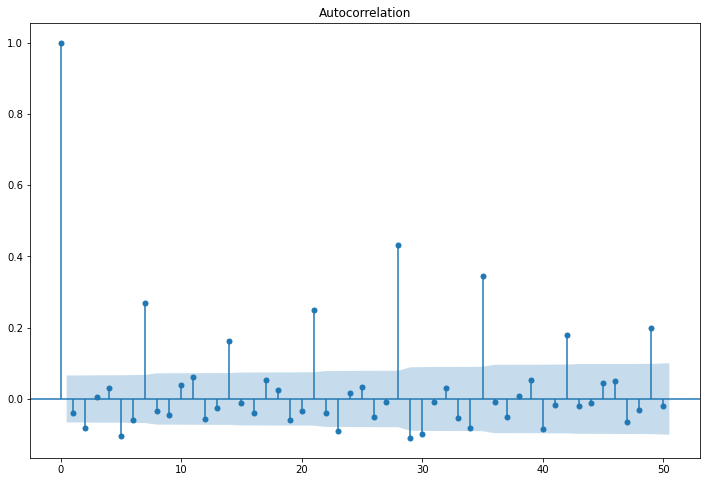

In [11]:
plt.figure(figsize=(12,8))
plot_acf(Store50_1044,lags=50,  ax=plt.gca())
plt.show()

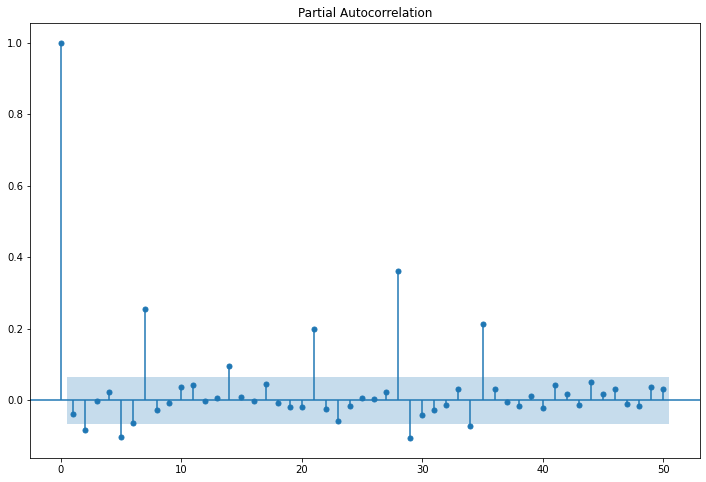

In [12]:
plt.figure(figsize=(12,8))
plot_pacf(Store50_1044, lags=50, ax=plt.gca())
plt.show()

In [13]:
## Seasonality after certain lags is visible. Every 7th day

In [14]:
### Data is being read again for model. This time no index is created while loading the data. First time when the data, index was used
## so that specific Explortory Data Analysis can be done.

In [15]:
Store50 = pd.read_excel("Store_50-1.xlsx",parse_dates=True)
# Extract customers only for store 1044 and the model would be built for this customer 
Store50_1044 = Store50[Store50.Store == 1044]
# reverse to the order: from 2013 to 2015
Store50_1044 = Store50_1044.sort_index(ascending = False)



In [16]:
Store50_1044.head()

,Store,Day Of Week,Date,Customers,Open,Promotion,State Holiday,School Holiday
43275,1044,2,2014-01-01 00:00:00,0,0,0,a,1
43224,1044,3,2014-02-01 00:00:00,481,1,0,0,1
43173,1044,4,2014-03-01 00:00:00,453,1,0,0,1
43122,1044,5,2014-04-01 00:00:00,497,1,0,0,1
43071,1044,6,2014-05-01 00:00:00,450,1,0,0,0


In [17]:
#Sanitisation Work
Store50_1044.rename(columns = {"Day Of Week": "DayOfWeek", "State Holiday":"StateHoliday","School Holiday":"SchoolHoliday"}, 
                      inplace = True) 

In [18]:
Store50_1044['Date'] = pd.to_datetime(Store50_1044['Date'])


In [19]:
Store50_1044['year']= Store50_1044['Date'].dt.year

In [20]:
Store50_1044.head()

,Store,DayOfWeek,Date,Customers,Open,Promotion,StateHoliday,SchoolHoliday,year
43275,1044,2,2014-01-01,0,0,0,a,1,2014
43224,1044,3,2014-02-01,481,1,0,0,1,2014
43173,1044,4,2014-03-01,453,1,0,0,1,2014
43122,1044,5,2014-04-01,497,1,0,0,1,2014
43071,1044,6,2014-05-01,450,1,0,0,0,2014


In [21]:
train=Store50_1044[Store50_1044['year'] !=2016]
test=Store50_1044[Store50_1044['year'] ==2016]

In [22]:
train_mod=train[['Date','Customers']]
test_mod=train[['Date','Customers']]

In [23]:
print(train.shape)
print(test.shape)

(730, 9)
(152, 9)


In [24]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

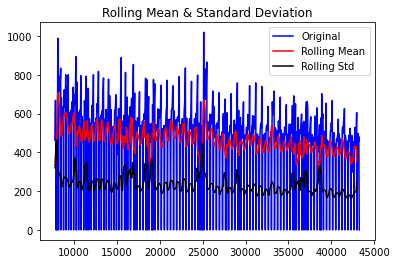

Results of Dickey-Fuller Test:
Test Statistic                  -2.872975
p-value                          0.048582
#Lags Used                      20.000000
Number of Observations Used    709.000000
Critical Value (1%)             -3.439607
Critical Value (5%)             -2.865625
Critical Value (10%)            -2.568945
dtype: float64 



In [25]:
test_stationarity(train['Customers'])

In [26]:
## Series is stationary and hence no need for differentiation

In [27]:
import itertools
p = q = range(0, 3)
d= range(0,1)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

print('Model: {}{}'.format(pdq[1], model_pdq[1]))
print('Model: {}{}'.format(pdq[1], model_pdq[2]))
print('Model: {}{}'.format(pdq[2], model_pdq[3]))
print('Model: {}{}'.format(pdq[2], model_pdq[4]))

Model: (0, 0, 1)(0, 0, 1, 7)
Model: (0, 0, 1)(0, 0, 2, 7)
Model: (0, 0, 2)(1, 0, 0, 7)
Model: (0, 0, 2)(1, 0, 1, 7)


In [28]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
print(ARIMA_AIC)


Empty DataFrame
Columns: [param, AIC]
Index: []


In [29]:
train['Customers']

43275      0
43224    481
43173    453
43122    497
43071    450
        ... 
7920     537
7878       0
7836     667
7794     668
7752     462
Name: Customers, Length: 730, dtype: int64

In [30]:
from statsmodels.tsa.arima_model import ARIMA

for param in pdq:
    ARIMA_model = ARIMA(train['Customers'],order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

ARIMA(0, 0, 0) - AIC:10018.497075995292
ARIMA(0, 0, 1) - AIC:9999.149162167298
ARIMA(0, 0, 2) - AIC:9993.000090076253
ARIMA(1, 0, 0) - AIC:10004.023773636363
ARIMA(1, 0, 1) - AIC:9994.564290452643
ARIMA(1, 0, 2) - AIC:9961.499492601195
ARIMA(2, 0, 0) - AIC:9993.938366700702
ARIMA(2, 0, 1) - AIC:9995.55787031632
ARIMA(2, 0, 2) - AIC:9787.496445477791


In [31]:
ARIMA_AIC.sort_values(by='AIC',ascending=True)

,param,AIC
8,"(2, 0, 2)",9787.496445
5,"(1, 0, 2)",9961.499493
2,"(0, 0, 2)",9993.000090
6,"(2, 0, 0)",9993.938367
4,"(1, 0, 1)",9994.564290
7,"(2, 0, 1)",9995.557870
1,"(0, 0, 1)",9999.149162
3,"(1, 0, 0)",10004.023774
0,"(0, 0, 0)",10018.497076


In [32]:
## ARIMA(2,0,2) has the lowest AIC
mod = ARIMA(train['Customers'], order=(2,0,2))

results_Arima = mod.fit()

print(results_Arima.summary())

                              ARMA Model Results                              
Dep. Variable:              Customers   No. Observations:                  730
Model:                     ARMA(2, 2)   Log Likelihood               -4887.748
Method:                       css-mle   S.D. of innovations            194.394
Date:                Sat, 02 Apr 2022   AIC                           9787.496
Time:                        22:16:40   BIC                           9815.055
Sample:                             0   HQIC                          9798.129
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             463.9097      7.167     64.731      0.000     449.863     477.956
ar.L1.Customers    -0.4445      0.001   -605.558      0.000      -0.446      -0.443
ar.L2.Customers    -0.9999      

In [33]:
test.Customers= test.Customers.astype(float)
final_hat_avg =test.copy()
pred = results_Arima.forecast(steps=152)

In [34]:
from sklearn.metrics import  mean_squared_error
rmse = mean_squared_error(test.Customers,pred[0],squared=False)
print(rmse)

236.99238409161575


In [35]:
resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['ARIMA(2,0,2)'])

resultsDf

,RMSE
"ARIMA(2,0,2)",236.992384


In [36]:
### As the dataset has seasonality.. Let's build the model with SARIMA

In [37]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
print(SARIMA_AIC)

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []


In [38]:
SARIMA_AIC

,param,seasonal,AIC


In [39]:
import statsmodels.api as sm

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train['Customers'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit()
        print('SARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
        

SARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:11185.950413292372
SARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:10518.569230074745
SARIMA(0, 0, 0)x(0, 0, 2, 7)7 - AIC:10040.609277392941
SARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:9521.374457632435
SARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:9016.226831861999
SARIMA(0, 0, 0)x(1, 0, 2, 7)7 - AIC:8914.949176594964
SARIMA(0, 0, 0)x(2, 0, 0, 7)7 - AIC:9122.879538850024
SARIMA(0, 0, 0)x(2, 0, 1, 7)7 - AIC:8919.558922744724
SARIMA(0, 0, 0)x(2, 0, 2, 7)7 - AIC:8885.374422412315
SARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:10844.339587952063
SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:10277.416370385214
SARIMA(0, 0, 1)x(0, 0, 2, 7)7 - AIC:9913.184015362163
SARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:9508.331991534702
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:8963.908102306596
SARIMA(0, 0, 1)x(1, 0, 2, 7)7 - AIC:8875.090651110668
SARIMA(0, 0, 1)x(2, 0, 0, 7)7 - AIC:9124.566045236747
SARIMA(0, 0, 1)x(2, 0, 1, 7)7 - AIC:8892.983128777423
SARIMA(0, 0, 1)x(2, 0, 2, 7)7 - AIC:8867.092277886353
SARIMA(0, 0, 2)x(0, 0, 

In [40]:
SARIMA_AIC.sort_values(by=['AIC']).head()

,param,seasonal,AIC
17,"(0, 0, 1)","(2, 0, 2, 7)",8867.092278
14,"(0, 0, 1)","(1, 0, 2, 7)",8875.090651
8,"(0, 0, 0)","(2, 0, 2, 7)",8885.374422
32,"(1, 0, 0)","(1, 0, 2, 7)",8885.432383
16,"(0, 0, 1)","(2, 0, 1, 7)",8892.983129


In [41]:
import statsmodels.api as sm

## SARIMA(0, 0, 1)(2, 0, 2, 7)
mod = sm.tsa.statespace.SARIMAX(train['Customers'],
                                order=(0,0,1),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_SARIMA = mod.fit()
print(results_SARIMA.summary())

                                       SARIMAX Results                                        
Dep. Variable:                              Customers   No. Observations:                  730
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -4427.546
Date:                                Sat, 02 Apr 2022   AIC                           8867.092
Time:                                        22:19:37   BIC                           8894.518
Sample:                                             0   HQIC                          8877.684
                                                - 730                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0032      0.023     -0.138      0.890      -0.048       0.042
ar.

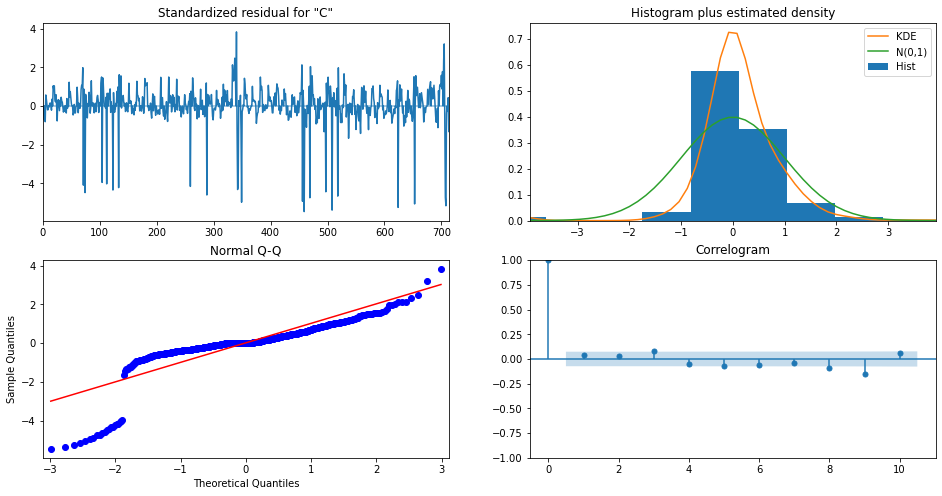

In [42]:
results_SARIMA.plot_diagnostics(figsize=(16, 8))
plt.show()

In [43]:
test.head()

,Store,DayOfWeek,Date,Customers,Open,Promotion,StateHoliday,SchoolHoliday,year
7701,1044,4,2016-01-01,0.0,0,0,a,1,2016
7650,1044,5,2016-02-01,633.0,1,0,0,1,2016
7599,1044,6,2016-03-01,530.0,1,0,0,0,2016
7548,1044,7,2016-04-01,0.0,0,0,0,0,2016
7497,1044,1,2016-05-01,845.0,1,1,0,1,2016


In [44]:
test.Customers= test.Customers.astype(float)
final_hat_avg =test.copy()
pred = results_SARIMA.get_forecast(steps=152)
pred.predicted_mean

730    640.513068
731    695.409939
732    615.839827
733      0.000486
734    730.593166
          ...    
877    599.237401
878    651.724334
879    634.553590
880      0.000481
881    757.915367
Name: predicted_mean, Length: 152, dtype: float64

In [45]:
pred.summary_frame()

Customers,mean,mean_se,mean_ci_lower,mean_ci_upper
730,640.513068,116.510192,412.157289,868.868847
731,695.409939,116.510772,467.053023,923.766855
732,615.839827,116.510772,387.482910,844.196743
733,0.000486,116.510772,-228.356430,228.357402
734,730.593166,116.510772,502.236249,958.950082
...,...,...,...,...
877,599.237401,117.729751,368.491330,829.983473
878,651.724334,117.729751,420.978263,882.470406
879,634.553590,117.729751,403.807518,865.299662
880,0.000481,117.729751,-230.745591,230.746552


In [46]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rmse)

149.29643250637548


In [47]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['SARIMA(0,0,1)(2,0,2)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.992384
"SARIMA(0,0,1)(2,0,2)7",149.296433


In [48]:
## To get the real forecast for 7 days, we will rerun the model on the complete dataset

mod = sm.tsa.statespace.SARIMAX(Store50_1044['Customers'],
                                order=(0,0,1),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:                              Customers   No. Observations:                  882
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -5416.706
Date:                                Sat, 02 Apr 2022   AIC                          10845.411
Time:                                        22:19:43   BIC                          10873.995
Sample:                                             0   HQIC                         10856.350
                                                - 882                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0119      0.023      0.510      0.610      -0.034       0.058
ar.

In [49]:
pred = results.get_forecast(steps=7)
pred.predicted_mean

882    665.777993
883    617.099553
884    590.141130
885    640.289677
886    619.571183
887     -0.002574
888    725.534451
Name: predicted_mean, dtype: float64

In [50]:
pred.summary_frame()

Customers,mean,mean_se,mean_ci_lower,mean_ci_upper
882,665.777993,123.915986,422.907124,908.648862
883,617.099553,123.924757,374.211493,859.987612
884,590.141130,123.920859,347.260709,833.021551
885,640.289677,123.920859,397.409256,883.170098
886,619.571183,123.920859,376.690763,862.451604
887,-0.002574,123.920859,-242.882995,242.877847
888,725.534451,123.920859,482.654030,968.414872


# SARIMAX Models

In [51]:
## This data set has exogeneous variables and hence the same should be considered while creating the model
## so to start with let's create a subset which only has exogeneous variables


In [52]:
ex_train=train[['Open','Promotion','StateHoliday','SchoolHoliday']]
ex_test=test[['Open','Promotion','StateHoliday','SchoolHoliday']]

In [53]:
## State variable has numeric character which has to be convered
ex_train["StateHoliday"].loc[ex_train["StateHoliday"] == "0"] = 0
ex_train["StateHoliday"].loc[ex_train["StateHoliday"] == "a"] = 1
ex_train["StateHoliday"].loc[ex_train["StateHoliday"] == "b"] = 2
ex_train["StateHoliday"].loc[ex_train["StateHoliday"] == "c"] = 3
ex_train.head()

,Open,Promotion,StateHoliday,SchoolHoliday
43275,0,0,1,1
43224,1,0,0,1
43173,1,0,0,1
43122,1,0,0,1
43071,1,0,0,0


In [54]:
ex_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 43275 to 7752
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Open           730 non-null    int64 
 1   Promotion      730 non-null    int64 
 2   StateHoliday   730 non-null    object
 3   SchoolHoliday  730 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 28.5+ KB


In [55]:
ex_train['StateHoliday'] = ex_train['StateHoliday'].astype('int64')
ex_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 43275 to 7752
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Open           730 non-null    int64
 1   Promotion      730 non-null    int64
 2   StateHoliday   730 non-null    int64
 3   SchoolHoliday  730 non-null    int64
dtypes: int64(4)
memory usage: 28.5 KB


In [56]:
## State variable has numeric character which has to be convered
ex_test["StateHoliday"].loc[ex_test["StateHoliday"] == "0"] = 0
ex_test["StateHoliday"].loc[ex_test["StateHoliday"] == "a"] = 1
ex_test["StateHoliday"].loc[ex_test["StateHoliday"] == "b"] = 2
ex_test["StateHoliday"].loc[ex_test["StateHoliday"] == "c"] = 3
ex_test.head()

,Open,Promotion,StateHoliday,SchoolHoliday
7701,0,0,1,1
7650,1,0,0,1
7599,1,0,0,0
7548,0,0,0,0
7497,1,1,0,1


In [57]:
ex_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 7701 to 0
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Open           152 non-null    int64 
 1   Promotion      152 non-null    int64 
 2   StateHoliday   152 non-null    object
 3   SchoolHoliday  152 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 5.9+ KB


In [58]:
ex_test['StateHoliday'] = ex_test['StateHoliday'].astype('int64')
ex_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 7701 to 0
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Open           152 non-null    int64
 1   Promotion      152 non-null    int64
 2   StateHoliday   152 non-null    int64
 3   SchoolHoliday  152 non-null    int64
dtypes: int64(4)
memory usage: 5.9 KB


In [59]:
SARIMAX_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
print(SARIMAX_AIC)

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []


In [60]:
## Let's first use SARIMAX with exogenous variable 

for param in pdq:
    for param_seasonal in model_pdq:
        mod = sm.tsa.statespace.SARIMAX(train['Customers'],exog=ex_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMAX = mod.fit()
        print('SARIMA{}{} - AIC:{}'.format(param, param_seasonal, results_SARIMAX.aic))
        SARIMAX_AIC = SARIMAX_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMAX.aic}, ignore_index=True)


SARIMA(0, 0, 0)(0, 0, 0, 7) - AIC:8449.698132723766
SARIMA(0, 0, 0)(0, 0, 1, 7) - AIC:8279.926343102528
SARIMA(0, 0, 0)(0, 0, 2, 7) - AIC:8108.89025250628
SARIMA(0, 0, 0)(1, 0, 0, 7) - AIC:8211.177164293795
SARIMA(0, 0, 0)(1, 0, 1, 7) - AIC:7981.845252332787
SARIMA(0, 0, 0)(1, 0, 2, 7) - AIC:7910.396181518098
SARIMA(0, 0, 0)(2, 0, 0, 7) - AIC:8009.100682711989
SARIMA(0, 0, 0)(2, 0, 1, 7) - AIC:7919.600161074247
SARIMA(0, 0, 0)(2, 0, 2, 7) - AIC:7892.712117723913
SARIMA(0, 0, 1)(0, 0, 0, 7) - AIC:8359.036965029212
SARIMA(0, 0, 1)(0, 0, 1, 7) - AIC:8198.543280681135
SARIMA(0, 0, 1)(0, 0, 2, 7) - AIC:8043.613104195383
SARIMA(0, 0, 1)(1, 0, 0, 7) - AIC:8157.242139252778
SARIMA(0, 0, 1)(1, 0, 1, 7) - AIC:7940.39047442307
SARIMA(0, 0, 1)(1, 0, 2, 7) - AIC:7865.360469208968
SARIMA(0, 0, 1)(2, 0, 0, 7) - AIC:7974.072466805534
SARIMA(0, 0, 1)(2, 0, 1, 7) - AIC:7885.554223404449
SARIMA(0, 0, 1)(2, 0, 2, 7) - AIC:7859.526348808538
SARIMA(0, 0, 2)(0, 0, 0, 7) - AIC:8317.247001195869
SARIMA(0, 0, 2

In [61]:
SARIMAX_AIC.sort_values(by=['AIC']).head()

,param,seasonal,AIC
53,"(1, 0, 2)","(2, 0, 2, 7)",7793.802945
50,"(1, 0, 2)","(1, 0, 2, 7)",7794.667578
71,"(2, 0, 1)","(2, 0, 2, 7)",7805.172648
41,"(1, 0, 1)","(1, 0, 2, 7)",7807.874695
44,"(1, 0, 1)","(2, 0, 2, 7)",7808.548815


In [62]:
## SARIMA(1, 0, 2)(2, 0, 2, 7)
mod = sm.tsa.statespace.SARIMAX(train['Customers'],exog=ex_train,
                                order=(1,0,2),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Customers   No. Observations:                  730
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 7)   Log Likelihood               -3884.901
Date:                           Sat, 02 Apr 2022   AIC                           7793.803
Time:                                   22:24:35   BIC                           7848.637
Sample:                                        0   HQIC                          7814.981
                                           - 730                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open            518.1318     22.446     23.084      0.000     474.139     562.125
Promotion        94.1517      6.96

In [63]:
pred = results.get_forecast(steps=152,exog=ex_test)
pred.predicted_mean

730     32.709148
731    588.279802
732    623.650681
733     -8.879075
734    811.749112
          ...    
877    547.425811
878    568.257571
879    601.693691
880     -1.187545
881    762.636625
Name: predicted_mean, Length: 152, dtype: float64

In [64]:
rmse_SARIMAX = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rmse_SARIMAX)

60.83493133729799


In [65]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse_SARIMAX]}
                           ,index=['SARIMAX(1,0,2)(2,0,2)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.992384
"SARIMA(0,0,1)(2,0,2)7",149.296433
"SARIMAX(1,0,2)(2,0,2)7",60.834931


In [66]:
## Let's use SARIMAX with exogenous variable whose coefficients are allowed to vary over time 
## Time Varying Linear Model[TVLM] SARIMA(1, 0, 2)(2, 0, 2, 7)
mod = sm.tsa.statespace.SARIMAX(train['Customers'],exog=ex_train,time_varying_regression=True,mle_regression=False,
                                order=(1,0,2),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Customers   No. Observations:                  730
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 7)   Log Likelihood               -3862.513
Date:                           Sat, 02 Apr 2022   AIC                           7749.026
Time:                                   22:24:41   BIC                           7803.793
Sample:                                        0   HQIC                          7770.184
                                           - 730                                         
Covariance Type:                             opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1                 0.4734      0.158      2.989      0.003       0.163       0.784
ma.L1                -

In [67]:
pred = results.get_forecast(steps=152,exog=ex_test)
pred.predicted_mean

730    -77.133703
731    626.444446
732    652.651586
733     -6.630557
734    875.944660
          ...    
877    564.817084
878    604.515886
879    639.602066
880     -0.297952
881    824.434894
Name: predicted_mean, Length: 152, dtype: float64

In [68]:
rmse_SARIMAX_timevarying = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rmse_SARIMAX_timevarying)

58.69395033453192


In [69]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse_SARIMAX_timevarying]}
                           ,index=['SARIMAX_tvlm(1,0,2)(2,0,2)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.992384
"SARIMA(0,0,1)(2,0,2)7",149.296433
"SARIMAX(1,0,2)(2,0,2)7",60.834931
"SARIMAX_tvlm(1,0,2)(2,0,2)7",58.693950


In [70]:
ex_1044=Store50_1044[['Open','Promotion','StateHoliday','SchoolHoliday']]

In [71]:
## State variable has numeric character which has to be convered
ex_1044["StateHoliday"].loc[ex_1044["StateHoliday"] == "0"] = 0
ex_1044["StateHoliday"].loc[ex_1044["StateHoliday"] == "a"] = 1
ex_1044["StateHoliday"].loc[ex_1044["StateHoliday"] == "b"] = 2
ex_1044["StateHoliday"].loc[ex_1044["StateHoliday"] == "c"] = 3
ex_1044.head()

,Open,Promotion,StateHoliday,SchoolHoliday
43275,0,0,1,1
43224,1,0,0,1
43173,1,0,0,1
43122,1,0,0,1
43071,1,0,0,0


In [72]:
ex_1044.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 43275 to 0
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Open           882 non-null    int64 
 1   Promotion      882 non-null    int64 
 2   StateHoliday   882 non-null    object
 3   SchoolHoliday  882 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 34.5+ KB


In [73]:
ex_1044['StateHoliday'] = ex_1044['StateHoliday'].astype('int64')
ex_1044.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 43275 to 0
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Open           882 non-null    int64
 1   Promotion      882 non-null    int64
 2   StateHoliday   882 non-null    int64
 3   SchoolHoliday  882 non-null    int64
dtypes: int64(4)
memory usage: 34.5 KB


In [74]:
## To get the real forecast for 7 days, we will rerun the model on the complete dataset

mod = sm.tsa.statespace.SARIMAX(Store50_1044['Customers'],exog=ex_1044,
                                order=(1,0,2),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Customers   No. Observations:                  882
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 7)   Log Likelihood               -4712.499
Date:                           Sat, 02 Apr 2022   AIC                           9448.997
Time:                                   22:24:49   BIC                           9506.150
Sample:                                        0   HQIC                          9470.872
                                           - 882                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open            532.4263     19.579     27.194      0.000     494.052     570.801
Promotion        96.4041      5.89

Role of Exogenous variables is not to reduce errors but to ensure to consider the additional variables in a practical way.

Now let's verify if the order as we got it using ACF and PACF gives you a better model in terms of performance.
So we will build two models with order=(0,0,0),seasonal_order=(1, 1,1, 7) and order=(0,0,1),seasonal_order=(1, 1,1, 7) for both 
SARIMAX with and without exogeneous variables
seasonality value for P and Q is assumed to be one because as per ACF and PACF plot seasonality was visible for every 7th period. 
In our SARIMAX loop in the earlier part of code we have assumed d to be 0. With this we will verify if first order differentiation makes a difference 
in terms of value of p and q both for the order and seasonal order.

In [75]:
## SARIMA(0, 0, 0)(1,1,1, 7) 
mod = sm.tsa.statespace.SARIMAX(train['Customers'],
                                order=(0,0,0),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 SARIMAX Results                                 
Dep. Variable:                 Customers   No. Observations:                  730
Model:             SARIMAX(1, 1, [1], 7)   Log Likelihood               -4447.653
Date:                   Sat, 02 Apr 2022   AIC                           8901.305
Time:                           22:24:50   BIC                           8915.022
Sample:                                0   HQIC                          8906.602
                                   - 730                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.1793      0.034     -5.256      0.000      -0.246      -0.112
ma.S.L7       -0.8971      0.019    -47.406      0.000      -0.934      -0.860
sigma2      1.464e+04    344

In [76]:
test.Customers= test.Customers.astype(float)
final_hat_avg =test.copy()
pred = results.get_forecast(steps=152)
pred.predicted_mean

730    642.531307
731    665.945208
732    593.709434
733      0.000000
734    746.046269
          ...    
877    544.846190
878    564.700437
879    585.087803
880      0.000000
881    734.028732
Name: predicted_mean, Length: 152, dtype: float64

In [77]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rms)

149.42542303818135


In [78]:
temp_resultsDf = pd.DataFrame({'RMSE': [rms]}
                           ,index=['SARIMA(0,0,0)(1,1,1)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.992384
"SARIMA(0,0,1)(2,0,2)7",149.296433
"SARIMAX(1,0,2)(2,0,2)7",60.834931
"SARIMAX_tvlm(1,0,2)(2,0,2)7",58.693950
"SARIMA(0,0,0)(1,1,1)7",149.425423


In [79]:
## SARIMA(0, 0, 1)(1,1,1, 7) 
mod = sm.tsa.statespace.SARIMAX(train['Customers'],
                                order=(0,0,1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Customers   No. Observations:                  730
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -4440.512
Date:                           Sat, 02 Apr 2022   AIC                           8889.024
Time:                                   22:24:51   BIC                           8907.308
Sample:                                        0   HQIC                          8896.085
                                           - 730                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0574      0.023      2.504      0.012       0.012       0.102
ar.S.L7       -0.1668      0.035     -4.796

In [80]:
test.Customers= test.Customers.astype(float)
final_hat_avg =test.copy()
pred = results.get_forecast(steps=152)
pred.predicted_mean

730    6.272193e+02
731    6.593675e+02
732    5.909295e+02
733   -1.002132e-06
734    7.422851e+02
           ...     
877    5.438530e+02
878    5.651201e+02
879    5.832210e+02
880   -8.588913e-07
881    7.315241e+02
Name: predicted_mean, Length: 152, dtype: float64

In [81]:
rms = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rms)

148.93879112523678


In [82]:
temp_resultsDf = pd.DataFrame({'RMSE': [rms]}
                           ,index=['SARIMA(0,0,1)(1,1,1)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.992384
"SARIMA(0,0,1)(2,0,2)7",149.296433
"SARIMAX(1,0,2)(2,0,2)7",60.834931
"SARIMAX_tvlm(1,0,2)(2,0,2)7",58.693950
"SARIMA(0,0,0)(1,1,1)7",149.425423
"SARIMA(0,0,1)(1,1,1)7",148.938791


In [83]:
## Exogeneous with order = (0,0,0) and seasonal order (1,1,1,7)
mod = sm.tsa.statespace.SARIMAX(train['Customers'],exog=ex_train,
                                order=(0,0,0),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 SARIMAX Results                                 
Dep. Variable:                 Customers   No. Observations:                  730
Model:             SARIMAX(1, 1, [1], 7)   Log Likelihood               -3947.705
Date:                   Sat, 02 Apr 2022   AIC                           7909.410
Time:                           22:24:54   BIC                           7941.416
Sample:                                0   HQIC                          7921.770
                                   - 730                                         
Covariance Type:                     opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open            511.1697     28.050     18.224      0.000     456.193     566.146
Promotion        98.6198      5.171     19.073      0.000      88.486     108.754
StateHoliday    

In [84]:
pred = results.get_forecast(steps=152,exog=ex_test)
pred.predicted_mean

730     37.019691
731    589.961973
732    644.590073
733      0.000000
734    827.523031
          ...    
877    562.189508
878    582.694475
879    634.539173
880      0.000000
881    816.465076
Name: predicted_mean, Length: 152, dtype: float64

In [85]:
rms = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rms)

67.55672711830509


In [86]:
temp_resultsDf = pd.DataFrame({'RMSE': [rms]}
                           ,index=['SARIMAX(0,0,0)(1,1,1)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.992384
"SARIMA(0,0,1)(2,0,2)7",149.296433
"SARIMAX(1,0,2)(2,0,2)7",60.834931
"SARIMAX_tvlm(1,0,2)(2,0,2)7",58.693950
"SARIMA(0,0,0)(1,1,1)7",149.425423
"SARIMA(0,0,1)(1,1,1)7",148.938791
"SARIMAX(0,0,0)(1,1,1)7",67.556727


In [87]:
## Exogeneous with order = (0,0,1) and seasonal order (1,1,1,7)
mod = sm.tsa.statespace.SARIMAX(train['Customers'],exog=ex_train,
                                order=(0,0,1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Customers   No. Observations:                  730
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -3923.871
Date:                           Sat, 02 Apr 2022   AIC                           7863.743
Time:                                   22:24:57   BIC                           7900.310
Sample:                                        0   HQIC                          7877.865
                                           - 730                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open            547.5995     25.177     21.750      0.000     498.254     596.945
Promotion        90.5543      5.93

In [88]:
pred = results.get_forecast(steps=152,exog=ex_test)
pred.predicted_mean

730   -6.598621e+00
731    5.949538e+02
732    6.419346e+02
733    8.135661e-10
734    8.187690e+02
           ...     
877    5.621274e+02
878    5.878533e+02
879    6.322897e+02
880    7.387889e-10
881    8.078643e+02
Name: predicted_mean, Length: 152, dtype: float64

In [89]:
rms = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rms)

64.78950284769954


In [90]:
temp_resultsDf = pd.DataFrame({'RMSE': [rms]}
                           ,index=['SARIMAX(0,0,1)(1,1,1)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.992384
"SARIMA(0,0,1)(2,0,2)7",149.296433
"SARIMAX(1,0,2)(2,0,2)7",60.834931
"SARIMAX_tvlm(1,0,2)(2,0,2)7",58.693950
"SARIMA(0,0,0)(1,1,1)7",149.425423
"SARIMA(0,0,1)(1,1,1)7",148.938791
"SARIMAX(0,0,0)(1,1,1)7",67.556727
"SARIMAX(0,0,1)(1,1,1)7",64.789503


In [91]:
## Exogeneous with order = (0,0,1) and seasonal order (1,1,1,7) - TVLM
mod = sm.tsa.statespace.SARIMAX(train['Customers'],exog=ex_train,time_varying_regression=True,mle_regression=False,
                                order=(0,0,1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Customers   No. Observations:                  730
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -2323.243
Date:                           Sat, 02 Apr 2022   AIC                           4662.486
Time:                                   22:25:05   BIC                           4699.008
Sample:                                        0   HQIC                          4676.594
                                           - 730                                         
Covariance Type:                             opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ma.L1                 1.2791   1.55e-19   8.27e+18      0.000       1.279       1.279
ar.S.L7              -

In [92]:
pred = results.get_forecast(steps=152,exog=ex_test)
pred.predicted_mean

730    2.319177e+01
731    5.056886e+02
732    4.699946e+02
733    2.653649e-13
734    4.940940e+02
           ...     
877    4.609469e+02
878    4.784658e+02
879    4.699946e+02
880    2.288402e-13
881    4.668712e+02
Name: predicted_mean, Length: 152, dtype: float64

In [93]:
rms = sqrt(mean_squared_error(test.Customers ,pred.predicted_mean))
print(rms)

197.718681071534


In [94]:
temp_resultsDf = pd.DataFrame({'RMSE': [rms]}
                           ,index=['SARIMAX_tvlm(0,0,1)(1,1,1)7'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,RMSE
"ARIMA(2,0,2)",236.992384
"SARIMA(0,0,1)(2,0,2)7",149.296433
"SARIMAX(1,0,2)(2,0,2)7",60.834931
"SARIMAX_tvlm(1,0,2)(2,0,2)7",58.693950
"SARIMA(0,0,0)(1,1,1)7",149.425423
"SARIMA(0,0,1)(1,1,1)7",148.938791
"SARIMAX(0,0,0)(1,1,1)7",67.556727
"SARIMAX(0,0,1)(1,1,1)7",64.789503
"SARIMAX_tvlm(0,0,1)(1,1,1)7",197.718681


In [ ]:
# So we found SARIMAX_tvim to be best model from rmse value. 
